## Data Preparation

In [93]:
import os
#os.listdir('./data/')

In terminal at current directory where association files from GWAS run in PLINK are present run:

head -2000 logistic_results.assoc_2.logistic.adjusted | awk '{ print $2 }' >> top2000_snps.txt 

top2000_snps.txt has the top 2000 SNPs associated with CN_AD GWAS logistic analysis

Now extract only the top 2000 snps geneomic data for CN_AD subjects {in GWAS_ADNI/CN_AD/QualityControl/}

plink --bfile GWAS_1_2_3_clean_CN_AD12 --make-bed --out GWAS_1_2_3_final_CN_AD12 #to make sure the files are sorted

NOTE: GWAS_1_2_3_clean_CN_AD12 is the final plink file set obtained after Quality Control Analysis

plink --bfile GWAS_1_2_3_final_CN_AD12 --extract top2000_snps.txt --recode --make-bed --out GWAS_CN_AD12

Finally we have GWAS_CN_AD12.ped file which contain genotype information in single line for each subject

FID,IID,FatherID,MotherID,Sex,Phenotype,Genotype:{Minor allele, Major allele} Sequence
starting from column 7 In the the form of pair minor allele and major allele. 

Which means

minor allele for snp1 is 7 and major allele for snp1 is 8;

minor allele for snp1 is 9 and major allele for snp1 is 10; 

and so on

Note: The missing genotypes are encoded with 00

In [94]:
import pandas as pd
from collections import Counter

In [95]:
df = pd.read_csv('./data/ADNIMERGE.csv',low_memory=False)
df_bl = df[df['VISCODE']=='bl']

In [96]:
Counter(df[df['VISCODE']=='bl']['DX_bl'])

Counter({'CN': 518, 'AD': 398, 'LMCI': 651, 'SMC': 301, 'EMCI': 389, nan: 12})

In [97]:
with open('./data/GWAS_CN_AD12.fam','r') as infile:
    text = infile.read().strip().split('\n')

PTID = [line.strip().split(' ')[1] for line in text]
    

In [98]:
df_GWAS = df_bl[pd.DataFrame(df_bl.PTID.tolist()).isin(PTID).any(1).values]

In [99]:
set(df_GWAS.PTID) == set(PTID)

True

In [100]:
Counter(df_GWAS['DX_bl'])

Counter({'AD': 195, 'CN': 325})

Prepare Genotype dataset as a matrix (195+325) x (2000 + 1(age) + 1(gender) + 1(education) + 1(Baseline Diagnosis) ) = 520 x 2004

In [101]:
def sequence_parser(t):
    
    t1 = [t[i].strip() for i in range(len(t)) if i%2 !=0]
    t2 = [t[i].strip() for i in range(len(t)) if i%2 ==0]
    Geno = [t1[i]+t2[i] for i in range(len(t1))]
    
    return Geno

In [102]:
data = []
with open('./data/GWAS_CN_AD12.ped','r') as infile:   
    text = infile.read().strip().split('\n')
    for line in text:
        gene = line.split(' ')[6:]
        PTID = line.split(' ')[1]
        AGE = df_GWAS[df_GWAS['PTID'] == PTID].AGE.item()
        GENDER = df_GWAS[df_GWAS['PTID'] == PTID].PTGENDER.item()
        EDU = df_GWAS[df_GWAS['PTID'] == PTID].PTEDUCAT.item()
        DIAG = df_GWAS[df_GWAS['PTID'] == PTID].DX_bl.item()
        GENOME = sequence_parser(gene)
        output = [PTID] + [AGE] + [GENDER] + [EDU] + [DIAG]+ GENOME
        data.append(output)
        
    

In [103]:
with open('./data/top2000_snps.txt') as infile:
    snps = infile.read().strip().split('\n')

In [104]:
column_names = ['PTID','AGE','GENDER','EDU']+['DIAG']+snps

In [105]:
df_final = pd.DataFrame(data,columns=column_names)
df_final.to_csv('./data/GWAS12_data_Dx_bl.csv')

In [106]:
#Number of top SNPs to take as features
N = 500
import pandas as pd
from collections import Counter

In [131]:
df_final = pd.read_csv('./data/GWAS_data_Dx_bl.csv',na_values=["00"])
df_final = df_final.iloc[:, 0:N+6] #Only top N snps
df_final = df_final.drop(columns=['Unnamed: 0'])
df_final.dropna(inplace=True)
Counter(df_final.DIAG)

Counter({'CN': 257, 'AD': 146})

In [132]:
df_final

,PTID,AGE,GENDER,EDU,DIAG,rs2075650,rs11253696,rs2136613,rs157580,rs6116375,...,rs2435588,rs13087917,rs6829532,rs2437994,rs17200294,rs17780119,rs338466,rs10248034,rs11144032,rs8062322
0,014_S_0520,77.7,Female,16,CN,GG,GG,TT,CC,CC,...,CT,CC,AA,CT,CC,TT,GG,GA,AA,GT
1,005_S_1341,71.6,Female,12,AD,GG,GG,TT,CC,CC,...,CC,CT,AC,CC,TT,TG,GG,GA,AA,GT
3,018_S_0055,75.5,Male,20,CN,GG,GG,TT,CC,CC,...,CT,CC,AA,CC,CC,GG,GG,GG,AA,GG
4,027_S_0118,80.4,Male,20,CN,GG,GG,TT,CC,CT,...,CC,CT,AC,CC,TT,GG,GG,GG,AA,GG
5,027_S_0403,76.3,Male,16,CN,GG,GG,TT,CC,CC,...,CC,CC,AA,CC,TT,TT,GG,GG,AA,GT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,024_S_4158,84.3,Male,18,CN,GG,GT,TT,CC,TT,...,TT,CT,AA,CC,CT,GG,GG,GA,AA,GG
537,024_S_4223,75.8,Male,16,AD,GG,GG,TT,CC,CC,...,CT,CC,AA,CC,CC,TG,GG,GG,AA,GG
539,018_S_4400,71.1,Male,20,CN,AA,GT,TC,CC,CT,...,TT,CC,AA,CC,CC,TT,GG,GG,AA,TT
541,041_S_4014,80.7,Male,16,CN,GG,GG,TT,CC,CT,...,CT,CT,AC,TT,CT,TG,GG,GG,AA,GT


In [169]:
from sklearn.preprocessing import LabelBinarizer
def prepare_targets(y):
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    return y

#Very inefficient approach! but is easier to visualize in my head
def data_prep(df): #This takes the dataframe and returns the one hot encoded expansion of input features
    target = prepare_targets(list(df.DIAG))
    df1 = df_final.drop(columns=['PTID','DIAG']).reset_index(drop=True) #Patient ID and DIAG not needed
    num_cols = ['AGE','EDU']
    cat_cols = list(set(df1.columns) - set(num_cols)) #Categorical features
    expand_cat = ['AGE','EDU'] #List of expanded categorical columns
    for cat in cat_cols:
        expand_cat = expand_cat + [str(cat)+'_'+ c for c in list(set(df1[cat]))]
    df_out = pd.DataFrame(columns=list(expand_cat))
    df_out['AGE'] = df1.AGE
    df_out['EDU'] = df1.EDU
    for i in range(len(df1)):
        row = df1.iloc[i]
        for col in cat_cols:
            item = row[col]
            df_out.at[i,str(col)+'_'+ item] = str(1)
        
    df_out = df_out.fillna(str(0))
    return df_out, target
df, y = data_prep(df_final)
print(df.shape, y.shape)

(403, 1499) (403,)


In [170]:
df

,AGE,EDU,rs618236_AA,rs618236_GA,rs618236_GG,rs344807_AA,rs344807_AG,rs344807_GG,rs9674507_AA,rs9674507_GA,...,rs1888540_GG,rs775146_CT,rs775146_TT,rs775146_CC,rs10924772_CT,rs10924772_TT,rs10924772_CC,rs9810583_AA,rs9810583_AC,rs9810583_CC
0,77.7,16,0,0,1,1,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0
1,71.6,12,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,75.5,20,0,0,1,1,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0
3,80.4,20,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
4,76.3,16,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,84.3,18,0,0,1,0,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
399,75.8,16,0,0,1,1,0,0,0,0,...,1,0,0,1,0,0,1,1,0,0
400,71.1,20,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,1,0
401,80.7,16,0,1,0,1,0,0,0,1,...,1,1,0,0,0,0,1,1,0,0


# Classifier

## Hyperparameters Grid Search

Adapted from https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

In [19]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)

In [171]:
X, y = df, y
# define model
model = GradientBoostingClassifier(random_state=1)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search space
space = dict()
space['n_estimators'] = [1500,2000,2100,2200,2500,3000,3500,4000]

scoring = {'AUC': 'roc_auc', 'Accuracy':'accuracy'}
# define search
search = GridSearchCV(model, space,n_jobs=-1, cv=cv,scoring=scoring, refit='Accuracy', return_train_score=True)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8295884773662551
Best Hyperparameters: {'n_estimators': 2500}


In [172]:
results = search.cv_results_

Automatically created module for IPython interactive environment


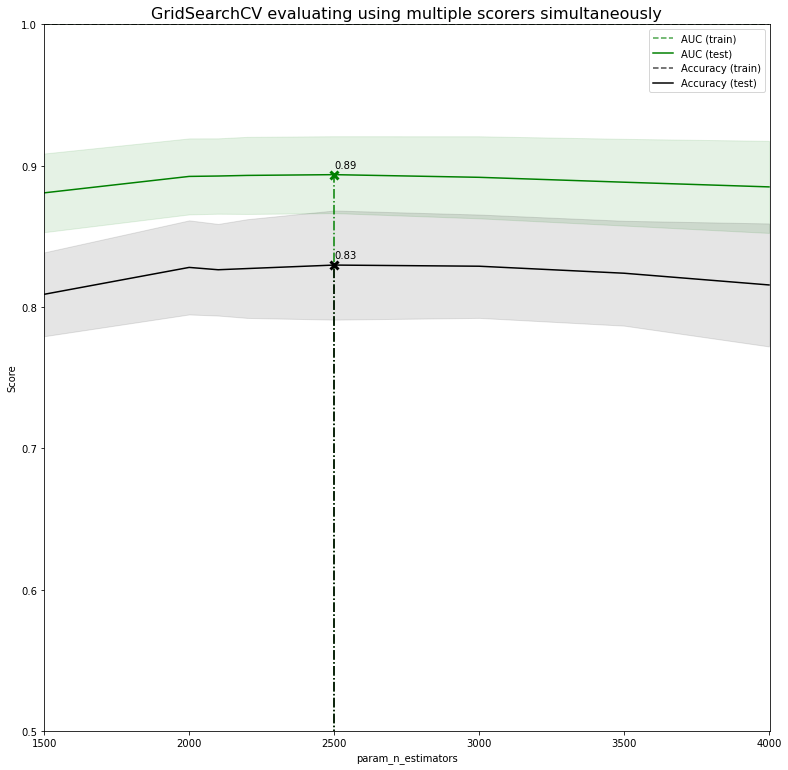

In [173]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD

results = search.cv_results_

import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

print(__doc__)


plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("param_n_estimators")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(1500, 4002)
ax.set_ylim(0.50, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()


In [178]:
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)

def classifier(name,n_estimators=100):
    if name == 'RandomForestClassifier':
        return RandomForestClassifier(n_estimators=n_estimators,criterion='gini',class_weight='balanced')
    
    if name == 'GradientBoosting':
        return GradientBoostingClassifier(n_estimators=n_estimators,random_state=1)
    
    else:
        raise NotImplementedError("This classifier is not implemented yet. Please choose from [RandomForest, GradientBoosting]")
        

In [180]:
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score, balanced_accuracy_score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
acc = []
f1 = []
auc = []
imp = []
for train, test in cv.split(X, y):
    X_train = X.iloc[train]
    y_train = y[train]
    
    X_test = X.iloc[test]
    y_test = y[test]
    
    n_estimators = 2500
    model = classifier('GradientBoosting', n_estimators)
    probas_ = model.fit(X_train, y_train).predict_proba(X_test)
    y_pred = model.predict(X_test)
    acc.append(balanced_accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred, average='macro'))
    auc.append(roc_auc_score(y_test, probas_[:, 1]))	    	
    imp.append(model.feature_importances_)
print(sum(acc)/len(acc))
print(sum(auc)/len(auc))

0.7940600891107992
0.8935605600920004


In [190]:
imp = np.array(imp)
imp = imp.mean(axis=0)
imp.shape

(1499,)

In [192]:
X.columns

Index(['AGE', 'EDU', 'rs618236_AA', 'rs618236_GA', 'rs618236_GG',
       'rs344807_AA', 'rs344807_AG', 'rs344807_GG', 'rs9674507_AA',
       'rs9674507_GA',
       ...
       'rs1888540_GG', 'rs775146_CT', 'rs775146_TT', 'rs775146_CC',
       'rs10924772_CT', 'rs10924772_TT', 'rs10924772_CC', 'rs9810583_AA',
       'rs9810583_AC', 'rs9810583_CC'],
      dtype='object', length=1499)

In [196]:
imp_df = pd.DataFrame(columns=['features','importance'])
imp_df['features'] = list(X.columns)
imp_df['importance'] = imp
imp_df

,features,importance
0,AGE,6.030480e-02
1,EDU,5.156636e-02
2,rs618236_AA,1.581451e-05
3,rs618236_GA,7.419207e-05
4,rs618236_GG,8.703995e-05
...,...,...
1494,rs10924772_TT,6.570545e-19
1495,rs10924772_CC,4.568138e-04
1496,rs9810583_AA,2.444978e-04
1497,rs9810583_AC,3.263090e-04


In [198]:
imp_df_sorted = imp_df.sort_values(by=['importance'],ascending=False)
imp_df_sorted

,features,importance
0,AGE,6.030480e-02
1,EDU,5.156636e-02
1137,rs10017065_GG,1.956355e-02
991,rs9306855_GG,1.715678e-02
1174,rs10099003_TT,1.593022e-02
...,...,...
962,rs12310569_AA,2.796182e-34
892,rs12522102_GG,2.619616e-34
1405,rs11144032_CC,1.210437e-34
638,rs4901474_AA,0.000000e+00


In [199]:
imp_df_sorted.to_csv('ranked_snps.csv')